# SMC2017: Exercise set I

## Setup

In [2]:
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## I.1 Importance sampling

Consider the target $\pi(x) = U(x; [0, 4])$ and let $q(x) = N(x; 0, 1)$ be given as a proposal distribution.

### a) Does this lead to a valid importance sampler? 

$q(x) > 0$ for all $x$. This is important since $\pi(x) > 0$ for $x \in [0, 4]$

### b) Implemention of an importance sampler

In [3]:
class TooLittleSampleCoverage(Exception):
    """Thrown if there were too few samples to hit the target distribution."""
    pass

def target(x, val=0.25):
    # Create a new array that will be populated with zeros 
    # except when the component of x is between 0.0 and 4.0
    y = np.zeros_like(x)
    y[np.logical_and(x >= 0.0, x <= 4.0)] = val
    return y
    
def imp_sample_exact(N, loc=0.0, scale=1.0):
    # Sample from the proposal
    samples = stats.norm.rvs(loc, scale, N)
    # Calculate the exact weights
    weights = target(samples) / \
              stats.norm.pdf(samples, loc=loc, scale=scale)
    
    return samples, weights

def imp_sample_prop(N, loc=0.0, scale=1.0):
    # Sample from the proposal
    samples = stats.norm.rvs(loc, scale, N)
    # Calculate the weights
    weights = target(samples, val=1) / \
              stats.norm.pdf(samples, loc=loc, scale=scale)
    # Normalize the weights
    if np.sum(weights) == 0.0:
        raise TooLittleSampleCoverage
    weights_normalized = weights / np.sum(weights)
    
    return samples, weights, weights_normalized

Plot the resulting distribution as a weighted histogram

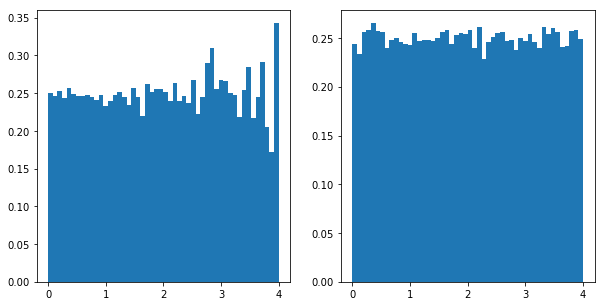

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Self-normalized
samples, weights, weights_normalized = imp_sample_prop(500000, loc=-3, scale=2)
axs[0].hist(samples, bins=50, weights=weights_normalized, 
            normed=True, range=(0, 4));

samples, weights, weights_normalized = imp_sample_prop(100000, loc=2, scale=2)
axs[1].hist(samples, bins=50, weights=weights_normalized, 
            normed=True, range=(0, 4));

If we use the exact proposal instead of the unscaled one:

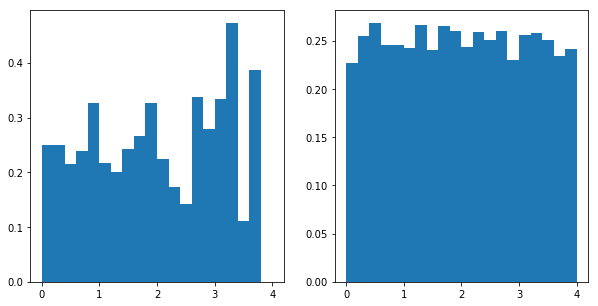

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Self-normalized
samples, weights = imp_sample_exact(10000, loc=-3, scale=2)
axs[0].hist(samples, bins=20, weights=weights, 
            normed=True, range=(0, 4));

samples, weights = imp_sample_exact(10000, loc=2, scale=2)
axs[1].hist(samples, bins=20, weights=weights, 
            normed=True, range=(0, 4));

The situation is not much better in this case. If the proposal covers the target distribution badly, then the resulting histogram will give a distorted image of the target distribution.

### c) Check for bias

Calculate mean value of $\pi(x)$ through importance sampling. Theoretical value: 2

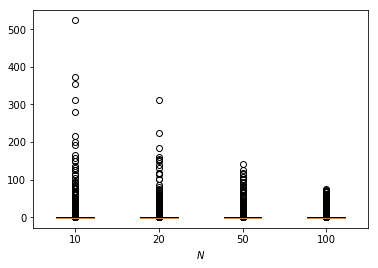

In [17]:
# Number of successful repetitions
M = 8000
# Values of N
ns = [10, 20, 50, 100]
exp_vals = np.zeros((M, len(ns)))

for i, N in zip(range(4), ns):
    j = 0
    while j < M:
        try:
            samples, weights = imp_sample_exact(N)
            exp_vals[j, i] = np.mean(samples * weights)
            j += 1
        except TooLittleSampleCoverage:
            pass

fig, ax = plt.subplots()
ax.boxplot(exp_vals - 2, labels=ns);
ax.set_xlabel('$N$');

Variance reduces with $N$ but bias is zero even for small $N$.

### d) Informal derivation of an estimator for the normalizing constant

It will be shown that
$$\widehat{Z} = \frac{1}{N} \sum_{i = 1}^N \widetilde{W}^i\quad\text{where}\quad\widetilde{W}^i = \frac{\widetilde{\pi}(X_i)}{q(X_i)}$$
is an estimator for the normalizing constant of the target distribution $\pi(x)$.

We can write the normalizing constant as
$$Z = \int \widetilde{\pi}(x)\,\mathrm{d}x = \int \frac{\widetilde{\pi}(x)}{q(x)} q(x)\,\mathrm{d}x$$

Replace the proposal with a Monte Carlo estimate, i.e.
$$q(x) \approx \frac{1}{N} \sum_{i = 1}^N \delta_{x^i}(x)\quad\text{and}\quad \omega(x) = \frac{\widetilde{\pi}(x)}{q(x)}$$
where $x^i$ are sampled from $q(x)$. This leads to
$$Z \approx \frac{1}{N} \sum_{i = 1}^{N} \omega(x^i) =: \widehat{Z}$$

### e) Bias and variance of the estimator for the normalizing constant

The theoretical value for the normalization constant is $4$.

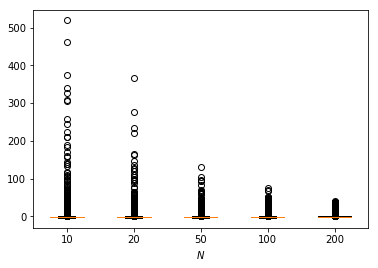

In [18]:
# Number of successful repetitions
M = 8000
# Values of N
ns = [10, 20, 50, 100, 200]
Z_vals = np.zeros((M, len(ns)))

for i, N in zip(range(len(ns)), ns):
    j = 0
    while j < M:
        try:
            samples, weights, weights_normalized = imp_sample_prop(N, loc=0, scale=1)
            Z_vals[j, i] = np.mean(weights)
            j += 1
        except TooLittleSampleCoverage:
            pass
    
fig, ax = plt.subplots()
ax.boxplot(Z_vals - 4, labels=ns);
ax.set_xlabel('$N$');

Variance decreases with $N$ while bias seems to be at zero even for small $N$.

It remains to check the influence of the proposal. Do this by moving the mean value of the proposal and by changing its standard deviation.

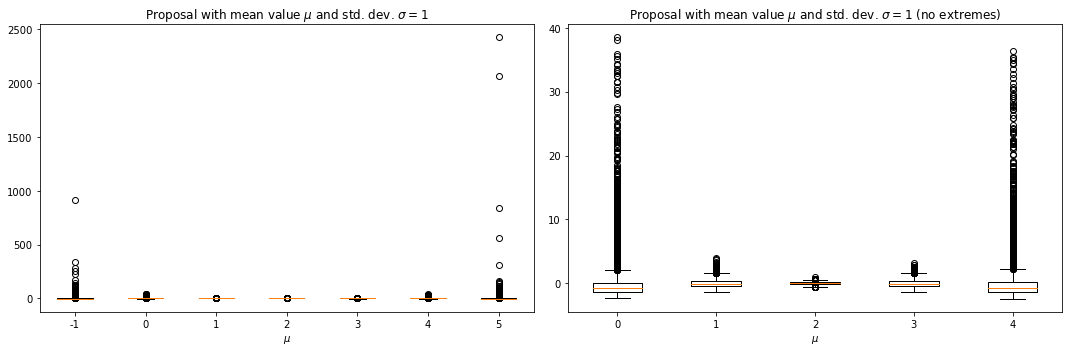

In [27]:
# Number of repetitions
M = 8000
# Values of mu
mus = [-1, 0, 1, 2, 3, 4, 5]
Z_vals = np.zeros((M, len(mus)))

for i, mu in zip(range(len(mus)), mus):
    j = 0
    while j < M:
        try:
            samples, weights, weights_normalized = imp_sample_prop(100, loc=mu, scale=1)
            Z_vals[j, i] = np.mean(weights)
            j += 1
        except TooLittleSampleCoverage:
            pass
    
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].boxplot(Z_vals - 4, labels=mus);
axs[0].set_title("Proposal with mean value $\mu$ and std. dev. $\sigma = 1$")
axs[0].set_xlabel("$\mu$");

axs[1].boxplot(Z_vals[:, 1:-1] - 4, labels=mus[1:-1])
axs[1].set_title("Proposal with mean value $\mu$ and std. dev. $\sigma = 1$ (no extremes)")
axs[1].set_xlabel("$\mu$");

fig.tight_layout()

Moving the Gaussian more to the midpoint of the uniform distribution reduces the variance to almost zero. Moving it away from the midpoint increases the variance a lot.

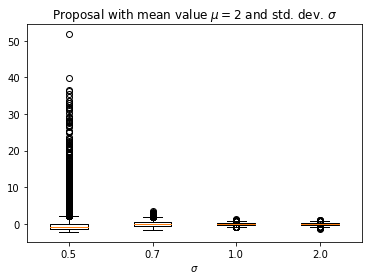

In [32]:
# Number of repetitions
M = 8000
# Values of sigma
sigmas = [0.5, 0.7, 1.0, 2.0]
Z_vals = np.zeros((M, len(sigmas)))

for i, sigma in zip(range(len(sigmas)), sigmas):
    j = 0
    while j < M:
        try:
            samples, weights, weights_normalized = imp_sample_prop(100, loc=2, scale=sigma)
            Z_vals[j, i] = np.mean(weights)
            j += 1
        except TooLittleSampleCoverage:
            pass
    
fig, ax = plt.subplots()
ax.boxplot(Z_vals - 4, labels=sigmas);
ax.set_title("Proposal with mean value $\mu = 2$ and std. dev. $\sigma$")
ax.set_xlabel("$\sigma$");

Higher standard deviation of the proposal also leads to less variance in the estimator. Probably because the tails, covering the uniform distribution, become heavier.

### f) Bias of estimator of expected value of the target distribution in case of self-normalized importance sampling

The theoretical value of the expected value is, as above, $2$.

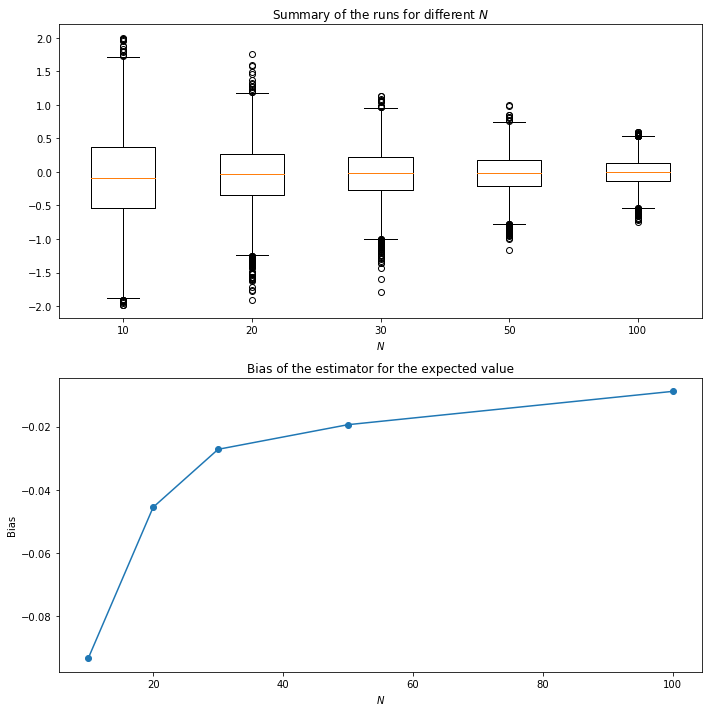

In [41]:
# Number of repetitions
M = 8000
# Values of N
ns = [10, 20, 30, 50, 100]
exp_vals = np.zeros((M, len(ns)))

for i, N in zip(range(len(ns)), ns):
    j = 0
    while j < M:
        try:
            samples, weights, weights_normalized = imp_sample_prop(N, scale=3)
            exp_vals[j, i] = np.sum(samples * weights_normalized)
            j += 1
        except TooLittleSampleCoverage:
            pass

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].boxplot(exp_vals - 2, labels=ns);
axs[0].set_xlabel('$N$');
axs[0].set_title('Summary of the runs for different $N$')

axs[1].plot(ns, exp_vals.mean(axis=0) - 2, 'o-')
axs[1].set_xlabel('$N$')
axs[1].set_ylabel('Bias')
axs[1].set_title('Bias of the estimator for the expected value');

fig.tight_layout()

g) The theoretical derivation is in the lecture notes. By considering
$$
\pi(x) = \frac{\widetilde{\pi}(x)}{Z}
$$
we get the estimator
$$
\widehat{I}^N(\phi) = \frac{1}{N \cdot Z} \sum_{i = 1}^N \widetilde{w}^i \phi(x^i)
$$
with $\phi(x) = x$ for the mean value. Considering that $Z$ can be approximated by
$$
\widehat{Z} = \frac{1}{N} \sum_{i = 1}^N \widetilde{w}^i
$$
as has been seen above, replacing $Z$ with $\widehat{Z}$ in the estimator $\widehat{I}^N$ above leads to
$$
\widehat{I}^N(\phi) = \sum_{i = 1}^N w^i \phi(x^i)\quad\text{where}\quad w^i = \frac{\widetilde{w}^i}{\sum_{j = 1}^N \widetilde{w}^j}.
$$
The difference between the two estimators is therefore essentially that the weights are normalized to sum to 1.

## I.2 Importance sampling in higher dimensions

Consider importance sampling in a $D$-dimensional space. Let the proposal $q(x) = N(x; 0, I_D)$ be the $D$-dimensional normal distribution and the target $\pi(x) = U(x; [-0.5, 0.5]^D)$. Exact evaluation of the target is allowed.

This means 
$$\pi(x) = \frac{1}{(0.5 - (-0.5))^D} \prod_{i = 1}^D 1_{[-0.5, 0.5]}(x_i) = \prod_{i = 1}^D 1_{[-0.5, 0.5]}(x_i)$$

In [43]:
def multivariate_uniform_pdf(x, a=-0.5, b=0.5):
    if np.alltrue(x >= a) and np.alltrue(x <= b):
        return 1
    else:
        return 0
    
def imp_sample(N, D):
    # Sample from the proposal
    samples = stats.multivariate_normal.rvs(np.zeros((D,)), np.identity(D), N)
    # Calculate exact weights
    weights = np.apply_along_axis(multivariate_uniform_pdf, 1, samples) / \
                stats.multivariate_normal.pdf(samples, mean=np.zeros((D,)), 
                                              cov=np.identity(D))
    
    return samples, weights

Create a histogram in two dimensions to see if the code works.

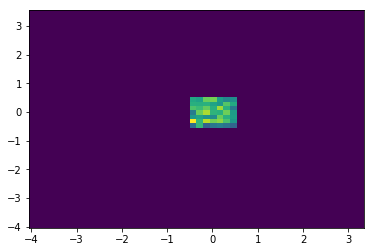

In [100]:
N = 8000
D = 2

fig, ax = plt.subplots()

samples, weights = imp_sample(N, D)
ax.hist2d(samples[:, 0], samples[:, 1], bins=50, weights=weights);

Iterate over the dimension and see how the proportion of non-zero weights develops.

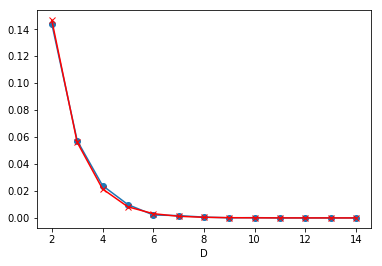

In [46]:
# Number of samples
N = 10000

proportion = []
probability = []

for D in range(2, 15):
    samples, weights = imp_sample(N, D)
    # Simulated proportion
    proportion.append(len(weights[weights != 0.0]) / len(weights))
    # Theoretical proportion
    probability.append(
        stats.mvn.mvnun(-0.5*np.ones((D,)), 0.5*np.ones((D,)), 
                        np.zeros((D,)), np.identity(D))[0])
    
proportion = np.array(proportion)
probability = np.array(probability)

fig, ax = plt.subplots()
ax.plot(range(2, 15), proportion, 'o-');
ax.plot(range(2, 15), probability, 'x-r');
ax.set_xlabel('D');

It seems that the effective amount of weights with non-zero value very rapidly converges to zero. It is so fast that it could be exponential decrease.

Theoretically the weights are
$$\omega(x^i) = \frac{\prod_{j = 1}^D I_{[-0.5, 0.5]}(x^i_j)}{\frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{1}{2} \|x^i\|^2\right)}.$$

With increasing dimension the probability of all components of the sample to be inside of the interval $[-0.5, 0.5]$ get lower and lower. Thus the number of zero samples increases.

The probability for all components of a sample from the $D$-dimensional normal distribution to be between $-0.5$ and $0.5$ is
$$P(-0.5 \leq x \leq 0.5) = P(x \leq 0.5) - P(x < -0.5) = 2 \cdot \Phi_D(0.5) - 1$$.

Here it holds that
$$
\begin{align}
\Phi_D(z) &= \int_{-\infty}^{z_1}\dots\int_{-\infty}^{z_D} \frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{1}{2} \|x\|^2\right)\,\mathrm{d}x = \\
&= \frac{1}{(2\pi)^{D/2}} \int_{-\infty}^{z_1} \exp\left(-\frac{1}{2} x_1^2\right)\,\mathrm{d}x_1\,\dots\,\int_{-\infty}^{z_D} \exp\left(-\frac{1}{2} x_D^2\right)\,\mathrm{d}x_D
\end{align}
$$
and thus
$$\Phi_D(0.5) = \Phi_1(0.5)^D \rightarrow 0\quad\text{for}\quad D \rightarrow \infty$$
since $\Phi_1(0.5) < 1$. This explains why the decrease is exponentially fast.

In [122]:
stats.norm.cdf(0.5)

0.69146246127401312

## I.3 An important numerical aspect

Consider $D = 1000$ for this exercise.

### a) Investigation of the weights

Consider the target $\pi(x) = \mathcal{N}\left(x;\,0,\,I_D\right)$ and the proposal $q(x) = \mathcal{N}\left(x;\,0,\,2^2 \cdot I_D\right)$.

In [70]:
# Set dimension
D = 1000

# Generate 10 samples from the proposal
samples = stats.multivariate_normal.rvs(cov=4 * np.eye(D), size=10)

# Calculate corresponding pdf values
pdf_target = np.product(stats.norm.pdf(samples), axis=1)
pdf_proposal = np.product(stats.norm.pdf(samples, scale=2), axis=1)

# Compute weights
weights = pdf_target / pdf_proposal
# and normalize them
weights_normalized = weights / np.sum(weights)

weights_normalized

C:\Users\Felix\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

The division fails since all values in `pdf_proposal` are numerically zero, even though they theoretically have a non-zero value. This results from the high number of dimensions and that every value $\mathcal{N}(x_k;\,0, 1)$ is quite likely to be below $1$.

### b) Use log of normal pdf instead

In [84]:
# Set dimension
D = 1000

# Generate 10 samples from the proposal
samples = stats.multivariate_normal.rvs(cov=4 * np.eye(D), size=10)

# Calculate corresponding pdf values
pdf_target = np.sum(stats.norm.logpdf(samples), axis=1)
pdf_proposal = np.sum(stats.norm.logpdf(samples, scale=2), axis=1)

# Compute log weights
logweights = pdf_target - pdf_proposal
# Retrieve normalized, non-log-transformed weights
weights_normalized = np.exp(logweights) / np.sum(np.exp(logweights))

(logweights, weights_normalized)

(array([-755.85532232, -738.26358416, -736.28918343, -750.43779578,
        -803.23536236, -853.42663221, -752.23150222, -819.14627139,
        -730.07020201, -821.21908075]),
 array([  0.00000000e+00,   2.75680719e-04,   1.98650597e-03,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   9.97737813e-01,
          0.00000000e+00]))

Sometimes the division by zero problem is mitigated but occasionally there is still some problem during the normalizsation step, since there are still quite a lot of zeros. These zeros are theoretically non-zero but tend to be of the form $\exp(-x)$ where $x$ is around $-800$ or lower. This cannot be handled by normal floating point arithmetics and the normalized weights end up being zero.

### c) Normalize weights

In [94]:
# Set dimension
D = 1000

# Generate 10 samples from the proposal
samples = stats.multivariate_normal.rvs(cov=4 * np.eye(D), size=10)

# Calculate corresponding pdf values
pdf_target = np.sum(stats.norm.logpdf(samples), axis=1)
pdf_proposal = np.sum(stats.norm.logpdf(samples, scale=2), axis=1)

# Compute log weights
logweights = pdf_target - pdf_proposal
# Maximum of the log weights
logweights_max = np.max(logweights)
# Shift the weights
logweights_shifted = logweights - logweights_max
# Retrieve normalized, non-log-transformed weights
weights_normalized = np.exp(logweights_shifted) / \
    np.sum(np.exp(logweights_shifted))

(logweights_shifted, weights_normalized)

(array([-124.5543934 ,    0.        , -235.82054133, -164.22090453,
         -82.55177605, -229.36041625,  -45.00087032,  -83.53735365,
         -45.99662086, -160.22782882]),
 array([  8.06704072e-055,   1.00000000e+000,   3.84096350e-103,
          4.78373759e-072,   1.40675734e-036,   2.45491725e-100,
          2.86002836e-020,   5.25035026e-037,   1.05662620e-020,
          2.59380962e-070]))

Now the log-weights are shifted towards a more reasonable order of magnitude which the floating point arithmetics can handle with better precision.

## I.4 Bootstrap particle filter for the stochastic volatility model

Consider the stochastic volatility model
$$
\begin{align}
x_t\,|\,x_{t - 1} &\sim N(x_t; \phi \cdot x_{t - 1}, \sigma^2) \\
y_t\,|\,x_t &\sim N(y_t; 0, \beta^2 \cdot \exp(x_t))
\end{align}
$$
with parameter vector $\theta = (\phi, \sigma, \beta)$.

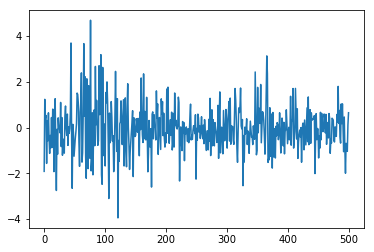

In [3]:
data = pd.read_csv('..\\base_material\\seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
y = data.logreturn.values

fig, ax = plt.subplots()
ax.plot(y)

Assume the parameter vector is given as $\theta = (0.98, 0.16, 0.70)$. 

In [4]:
theta = [0.98, 0.16, 0.70]

def bootstrap_pf(N, y):
    # Save the history
    xs = []
    ws = []
    # Initialisation
    samples = stats.norm.rvs(0, theta[1], N)
    weights = 1 / N * np.ones((N,))
    weights_normalized = weights
    
    # Save weights and samples
    ws.append(weights_normalized)
    xs.append(samples)
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        # Randomly choose ancestors
        ancestors = np.random.choice(samples, size=N, 
                                     replace=True, p=weights_normalized)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) * theta[1] + theta[0] * ancestors
        # Save the new x
        xs.append(samples)
        
        # Weight
        weights = stats.norm.logpdf(y[t], loc=0,
                                    scale=(theta[2] * np.exp(samples / 2)))
        # Substract maximum
        weights = weights - np.max(weights)
        # Normalize weights to be probabilities
        weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
        # Save the new normalized weights 
        ws.append(weights_normalized)
        
    return np.array(xs), np.array(ws)

Execute the bootstrap particle filter

In [8]:
xs, ws = bootstrap_pf(500, y)

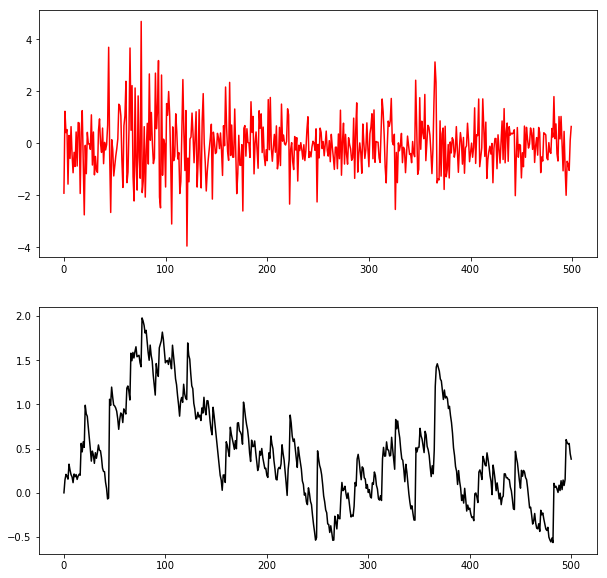

In [9]:
xs_means = np.apply_along_axis(np.sum, 1, ws * xs)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y, 'r');
axs[1].plot(xs_means, 'k');

When there is more variability in the time series then the estimated volatility is higher as well and vice versa. The estimate therefore seems to be reasonable.

## I.5 Bootstrap particle filter central limit theorem

This is a theoretical exercise and my solution can be found in `exercises_on_paper`.